In [83]:
import requests
import time
import pandas as pd
import json
import csv
import numpy as np
import re

**Part I. Data Collection**



Collection of New York Times articles with the word "anxiety" or "depression" on the headline (NATASHA)

In [63]:
#Basic details needed to interact with The New York Times API
api_key = "" #deleted after interaction with the API
base_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

def collect_articles_NYT(word, output_file_name): 
    '''
    Interact with The New York Times API to collect articles' data. Restrict
    the search to those articles containing the given word in the headline.
    Lastly, generate a json file to store the data so it can be easily 
    retrieved later without needing to make requests every time. 

    Inputs: 
        word (str): word of interest for the query
        output_file_name (str): desired name for the json file to be created

    Outputs:
        json file
    '''

    articles = {}

    for year in range(2004,2025):

        year_data = []

        #Since the API only retrieves 10 results per query, we have to loop 
        #through different pages. The range 0-100 is set up since it is the
        #maximum number of pages that can be requested.
        for page in range(0,100):

            begindate = "{}0101".format(year)
            enddate = "{}1231".format(year)
            nyt_params = {"q": word, "fq": f'headline:{word}',
                        "begin_date": begindate, "end_date": enddate, 
                        "page": page, "api-key": api_key}
            
            response = requests.get(base_url, params= nyt_params)
            page_data = response.json()
            time.sleep(14)

            #After collecting all available data, subsequent pages retrieve
            #empty results. For that reason, we can break the loop when pages 
            #are no longer useful. It also avoids making unnecessary and 
            #time-consuming requests
        
            if len(page_data["response"]["docs"]) == 0:
                break

            year_data += page_data["response"]["docs"]

        articles[year] = year_data

    #Export the dictionary to a JSON file to save it locally to avoid needing
    #to make requests every time we work on the project. 
    with open(output_file_name, 'w') as json_file:
        json.dump(articles, json_file, indent=4)


#Call function to retrieve NYT articles related to anxiety and depression

#collect_articles_NYT("anxiety", "anxiety_articles_NYT.json")
#collect_articles_NYT("depression", "depression_articles_NYT.json")

Collection of The Guardian's articles with the word "anxiety" or "depression" on the headline (YUE)

In [64]:
#according to chatgpt, i added pages and loop through each pages. 
def search_guardian_api(api_key, query, from_date, to_date):
    base_url = "https://content.guardianapis.com/search"
    
    params = {
        'api-key': api_key,
        'q': query,
        'order-by': 'newest',
        'from-date': from_date,
        'to-date': to_date,
        'show-fields': 'headline,bodyText,webPublicationDate',  
        'section': 'society' or 'wellness' 
    }
    
    all_articles = []
    page = 1
    total_articles = float('inf')  # Initialize to infinity
    
    while len(all_articles) < total_articles:
        params['page'] = page
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            data = response.json()
            articles = data.get('response', {}).get('results', [])
            total_articles = data.get('response', {}).get('total', 0)
            
            for article in articles:
                headline = article.get('fields', {}).get('headline', '')
                publication_date = article.get('webPublicationDate', '')
                body_text = article.get('fields', {}).get('bodyText', '')
                all_articles.append({'Headline': headline, 
                 'Publication Date': publication_date, 'Body Text': body_text})
            
            page += 1
        else:
            print(f"Error: {response.status_code}, {response.text}")
            break
    
    return all_articles

api_key = ' ' #deleted after collection
from_date = '2004-01-01'
to_date = '2024-02-07'

#Call to retrieve anxiety articles
query = 'anxiety'
#anxiety_articles = search_guardian_api(api_key, query, from_date, to_date)
#df = pd.DataFrame(anxiety_articles)
#df.to_csv('anxiety_articles.csv', index=False)

#Call to retrieve depression articles
query = 'depression'
#depression_articles = search_guardian_api(api_key, query, from_date, to_date)
#df = pd.DataFrame(depression_articles)
#df.to_csv('depression_articles.csv', index=False)

Collecting total number of articles published (yearly) on The New York Times for the past 20 years (NATASHA)

In [65]:
total_n_nyt = {}

for year in range(2004,2025):
    
    begindate = "{}0101".format(year)
    enddate = "{}1231".format(year)
    nyt_params = { "begin_date": begindate, "end_date": enddate, 
                   "api-key": api_key}
            
    #response = requests.get(base_url, params= nyt_params)
    #data = response.json()

    #Extract number of total articles from the metadata. ("Hits" refers to
    #total number of results
    #total_n_articles = data["response"]["meta"]["hits"]
    #time.sleep(12)

    #total_n_nyt[year] = total_n_articles

#with open("yearly_n_all_nyt", 'w') as json_file:
    #json.dump(total_n_nyt, json_file, indent=4)

with open("./yearly_n_all_nyt", "r") as json_file:
        total_n_nyt = json.load(json_file)

#I asked ChatGPT: "how can I convert a dictionary of keys with just one value 
#"into a pandas dataframe?" and it gave me the following code: 

df_all_yearly_nyt= pd.DataFrame.from_dict(total_n_nyt, orient='index', 
                            columns=['Total number of articles'])



Collecting total number of articles published (monthly) on The New York Times on the timeframe between July 1, 2019 and January 31, 2024 (NATASHA)

In [66]:
#Create list of begin days and end days for the requests

formatted_dates = []

for year in range(2019, 2025):
    for month in range(1,13):
        f_month = '{:02d}'.format(month)
        beginday = "{}{}01".format(year, f_month)
        if month in [4, 6, 9, 11]:
            endday = "{}{}30".format(year, f_month)
        elif month == 2 and year == 2020:
            endday = "{}{}29".format(year, f_month)
        elif month == 2:
            endday = "{}{}28".format(year, f_month)
        else:
            endday = "{}{}31".format(year, f_month)

        formatted_dates.append((beginday, endday))  

#Removing months before July 2019 and after January 2024
useful_dates = formatted_dates[6:61]

#Create dictionary to store monthly counts

monthly_total_nyt = {}

for month in useful_dates:
    beginday, endday = month

    nyt_params = { "begin_date": beginday, "end_date": endday, 
                   "api-key": api_key}
    
    #response = requests.get(base_url, params= nyt_params)
    #data = response.json()
    #total_n_articles_month = data["response"]["meta"]["hits"]
    #monthly_total_nyt[month] = total_n_articles_month
    #time.sleep(12)

#Store the info in a csv file
csv_file = 'monthly_n_nyt.csv'

#with open(csv_file, 'w', newline='') as file:
    #writer = csv.writer(file)
    
    #for key, value in monthly_total_nyt.items():
        #writer.writerow([key, value])

#Create dataframe 
df_all_monthly_nyt = pd.read_csv('monthly_n_all_nyt.csv', names= ["Month", "Count of all articles"])
 
        

Collecting total number of articles published (yearly) on The Guardian for the past 20 years (YUE)

In [67]:
def count_articles_by_year(api_key, from_date, to_date):
    base_url = "https://content.guardianapis.com/search"
    
    total_articles_by_year = {}
    
    # Extract start and end years
    start_year = int(from_date[:4])
    end_year = int(to_date[:4]) + 1  # Add 1 to include the end year
    
    for year in range(start_year, end_year):
        # Set the from-date and to-date parameters for the current year
        year_from_date = f"{year}-01-01"
        year_to_date = f"{year}-12-31"
        
        params = {
            'api-key': api_key,
            'from-date': year_from_date,
            'to-date': year_to_date,
            'page-size': 1,  # Set page size to 1 as we're only interested in checking the existence of articles
        }
        
        response = requests.get(base_url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            total = data.get('response', {}).get('total', 0)
            total_articles_by_year[str(year)] = total
        else:
            print(f"Error: {response.status_code}, {response.text}")
            total_articles_by_year[str(year)] = 0  # Set count to 0 for the current year in case of error
    
    return total_articles_by_year

# Example usage:
api_key = '93eb884c-6abd-444e-aba9-95bba2d84dad'
from_date = '2004-01-01'
to_date = '2024-02-07'

#total_articles_by_year = count_articles_by_year(api_key, from_date, to_date)

#We copied the dictionary to a csv file "yearly_n_all_guardian.csv" to store it 


**Part II. Data Cleaning**

Create initial dataframes for NYT articles (NATASHA)

In [68]:
def create_df_NYT_articles(jsonfilepath): 
    '''
    Given a JSON file containing NYT's articles data, create a data frame that 
    contains useful information 

    Inputs: 
        jsonfilepath (str): name of the file preceeded by its path

    Returns:
        DataFrame containing information of the articles (year published,
        specific date, headlines and abstracts)
    '''

    #Open json file as a python dictinary
    with open(jsonfilepath, "r") as json_file:
        dictdata = json.load(json_file)

    #Loop through each item in the dictionary to get the most relevant information
    #of the articles and store it in a dataframe

    cols = {"year" : [], "specific_date": [], "section": [], 'subsection': [],
                                                 'headlines':[], 'abstracts':[]}

    for year_x in range(2004,2025):
        year_data = dictdata[str(year_x)]
        for index, article in enumerate(year_data):

            
            cols["year"].append(year_x)
            cols['specific_date'].append(article['pub_date'])
            cols['headlines'].append(article["headline"]["main"])
            cols['abstracts'].append(article['abstract'])

            try:
                cols['section'].append(article["section_name"])
            except:
                cols['section'].append(None)

            try:
                cols['subsection'].append(article["subsection_name"])
            except:
                cols['subsection'].append(None)

    df = pd.DataFrame(cols)
    return df

#Call function to create data frame for NYT's anxiety articles
anx_nyt_df = create_df_NYT_articles("./anxiety_articles_NYT.json")

#Create dataframe for NYT's depression articles
dep_nyt_df = create_df_NYT_articles("./depression_articles_NYT.json")


Further cleaning (JAYDA)

In [81]:
# create function to clean nyt data frame
def clean_nyt_df(df, anxiety_depression_ID):
    # filter out Great Depression articles
    new_df = df.drop(df[df['headlines'].str.contains("Great Depression")].index)

    # add NYT id
    new_df["Sources"] = 0

    # add anxiety_depression_ID
    new_df["Anxiety or Depression"] = anxiety_depression_ID

    # standardize date format
    new_df["specific_date"] = new_df["specific_date"].astype(str)
    new_df["date"] = new_df["specific_date"].str.extract(r"(.{10})T", expand=True)

    # make time frame variable
    new_df["date"] = pd.to_datetime(new_df["date"])

    pre = pd.to_datetime("2020-03-11")
    post = pd.to_datetime("2024-05-11")

    time_frames = [
        (new_df["date"] < pre),
        (new_df["date"] < post)]

    values = [0, 2]

    new_df['Time frame'] = np.select(time_frames, values, default=1)

    # make month and day variables
    new_df["Month"] = new_df["specific_date"].str.extract(r"-([0-9]{2})", expand=True)
    new_df["Date"] = new_df["specific_date"].str.extract(r"([0-9]{2})T", expand=True)
    new_df["Year"] = new_df["year"]

    # clean headlines and abstracts 
    new_df["Title"]  = [re.sub(r'[^\w\s]', '', i).lower() for i in new_df["headlines"]]
    new_df["Abstract"]  = [re.sub(r'[^\w\s]', '', i).lower() for i in new_df["abstracts"]]

    return new_df

In [84]:
clean_nyt_anx = clean_nyt_df(anx_nyt_df, 0)
clean_nyt_anx.head()

,year,specific_date,section,subsection,headlines,abstracts,Sources,Anxiety or Depression,date,Time frame,Month,Date,Year,Title,Abstract
0,2004,2004-03-14T05:00:00+0000,Arts,None,High Anxiety,James Glanz article on safety precautions bein...,0,0,2004-03-14,0,03,14,2004,high anxiety,james glanz article on safety precautions bein...
1,2004,2004-08-22T05:00:00+0000,Books,None,'Status Anxiety',"""Money, fame and influence may be valued more ...",0,0,2004-08-22,0,08,22,2004,status anxiety,money fame and influence may be valued more as...
2,2004,2004-12-06T05:00:00+0000,Archives,None,Anxiety for an American Family,"Interview with Carolyn Richard, Adairsville, G...",0,0,2004-12-06,0,12,06,2004,anxiety for an american family,interview with carolyn richard adairsville ga ...
3,2004,2004-09-05T05:00:00+0000,Books,None,Short Stories: Anxiety Attacks,Jeff Turrentine reviews books The Secret Goldf...,0,0,2004-09-05,0,09,05,2004,short stories anxiety attacks,jeff turrentine reviews books the secret goldf...
4,2004,2004-02-29T05:00:00+0000,Sports,None,"High Velocity, Some Anxiety",New York Yankees pitcher Kevin Brown prepares ...,0,0,2004-02-29,0,02,29,2004,high velocity some anxiety,new york yankees pitcher kevin brown prepares ...


In [85]:
clean_nyt_dep = clean_nyt_df(dep_nyt_df, 1)
clean_nyt_dep.head()

,year,specific_date,section,subsection,headlines,abstracts,Sources,Anxiety or Depression,date,Time frame,Month,Date,Year,Title,Abstract
0,2004,2004-12-10T05:00:00+0000,U.S.,None,Study Pursues a Genetic Link to Depression,Scientists at Duke University find genetic var...,0,1,2004-12-10,0,12,10,2004,study pursues a genetic link to depression,scientists at duke university find genetic var...
1,2004,2004-12-17T05:00:00+0000,U.S.,None,Study Suggests Way to Predict Whom Antidepress...,Harvard and UCLA researchers find that common ...,0,1,2004-12-17,0,12,17,2004,study suggests way to predict whom antidepress...,harvard and ucla researchers find that common ...
2,2004,2004-12-07T05:00:00+0000,Health,None,Tracking Stress and Depression Back to the Womb,Studies indicate that stress and depression in...,0,1,2004-12-07,0,12,07,2004,tracking stress and depression back to the womb,studies indicate that stress and depression in...
3,2004,2004-09-12T05:00:00+0000,Business Day,None,"Depression, a Frequent Visitor to Wall St.",Rate of chronic depression seems to be high am...,0,1,2004-09-12,0,09,12,2004,depression a frequent visitor to wall st,rate of chronic depression seems to be high am...
4,2004,2004-08-25T05:00:00+0000,U.S.,None,New Therapy On Depression Finds Phone Is Effec...,Study reported in Journal of the American Medi...,0,1,2004-08-25,0,08,25,2004,new therapy on depression finds phone is effec...,study reported in journal of the american medi...


In [86]:
# combine data frames and filter desired columns
filter = ["Sources", "Month", "Date", "Year", "Anxiety or Depression", "Title", "Abstract", "Time frame"]
clean_nyt = pd.concat([clean_nyt_anx, clean_nyt_dep], axis=0)[filter]

clean_nyt.to_csv("clean_nyt", sep=',', index=False)

**Part III. Data Analysis**

Proportion of Anxiety articles among all articles from The Guardian (YUE)

In [69]:
query = 'anxiety'
anxiety_articles = search_guardian_api(api_key, query, from_date, to_date)
df = pd.DataFrame(anxiety_articles)


In [77]:
df.to_csv('anxiety_articles.csv', index=False)

In [87]:
# Convert 'Publication Date' column to datetime
df['Publication Date'] = pd.to_datetime(df['Publication Date'])

# Extract year from 'Publication Date' and create a new column
df['Year'] = df['Publication Date'].dt.year

# Count the number of articles for each year
yearly_counts = df['Year'].value_counts().sort_index()

# Display the yearly counts    
print(yearly_counts)  


Year
2004    156
2005    146
2006    107
2007     94
2008     99
2009     87
2010     68
2011    135
2012     78
2013    113
2014    145
2015    140
2016    206
2017    183
2018    198
2019    203
2020    215
2021    193
2022    191
2023    168
2024     24
Name: count, dtype: int64


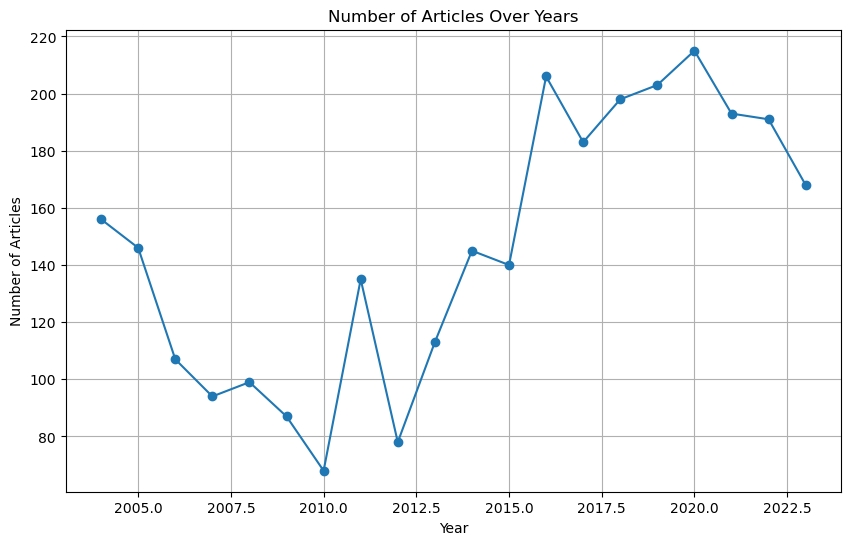

In [71]:
import matplotlib.pyplot as plt

# Provided data
years = list(range(2004, 2024))
values = [
    156, 146, 107, 94, 99, 87, 68, 135, 78, 113,
    145, 140, 206, 183, 198, 203, 215, 193, 191,
    168
]

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(years, values, marker='o', linestyle='-')

# Add labels and title
plt.title('Number of Articles Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Articles')

# Show grid
plt.grid(True)

# Show plot
plt.show()

I got rid of 2024 becasue it's misleading as we only have data for 2 months

In [72]:
# Define the counts of anxiety articles
anxiety_counts = {
    2004: 156, 2005: 146, 2006: 107, 2007: 94, 2008: 99, 2009: 87, 2010: 68,
    2011: 135, 2012: 78, 2013: 113, 2014: 145, 2015: 140, 2016: 206, 2017: 183,
    2018: 198, 2019: 203, 2020: 215, 2021: 193, 2022: 191, 2023: 168, 2024: 24
}

# Define the total counts of articles for each year
total_articles = {
    2004: 97873, 2005: 99939, 2006: 108381, 2007: 125860, 2008: 144090, 2009: 122035,
    2010: 108920, 2011: 118663, 2012: 120930, 2013: 125551, 2014: 123103, 2015: 118486,
    2016: 110396, 2017: 85363, 2018: 80131, 2019: 78754, 2020: 78924, 2021: 76842,
    2022: 78967, 2023: 77315, 2024: 10121
}

# Calculate the proportion of anxiety articles to total articles for each year
proportion_anxiety_articles = {}
for year in range(2004, 2025):
    if total_articles[year] != 0:  # Avoid division by zero
        proportion_anxiety_articles[year] = anxiety_counts[year] / total_articles[year]
    else:
        proportion_anxiety_articles[year] = 0  # If total articles is 0, set proportion to 0

# Display the proportion of anxiety articles published for each year
for year, proportion in proportion_anxiety_articles.items():
    print(f"Year: {year}, Proportion of Anxiety Articles: {proportion:.4f}")

Year: 2004, Proportion of Anxiety Articles: 0.0016
Year: 2005, Proportion of Anxiety Articles: 0.0015
Year: 2006, Proportion of Anxiety Articles: 0.0010
Year: 2007, Proportion of Anxiety Articles: 0.0007
Year: 2008, Proportion of Anxiety Articles: 0.0007
Year: 2009, Proportion of Anxiety Articles: 0.0007
Year: 2010, Proportion of Anxiety Articles: 0.0006
Year: 2011, Proportion of Anxiety Articles: 0.0011
Year: 2012, Proportion of Anxiety Articles: 0.0006
Year: 2013, Proportion of Anxiety Articles: 0.0009
Year: 2014, Proportion of Anxiety Articles: 0.0012
Year: 2015, Proportion of Anxiety Articles: 0.0012
Year: 2016, Proportion of Anxiety Articles: 0.0019
Year: 2017, Proportion of Anxiety Articles: 0.0021
Year: 2018, Proportion of Anxiety Articles: 0.0025
Year: 2019, Proportion of Anxiety Articles: 0.0026
Year: 2020, Proportion of Anxiety Articles: 0.0027
Year: 2021, Proportion of Anxiety Articles: 0.0025
Year: 2022, Proportion of Anxiety Articles: 0.0024
Year: 2023, Proportion of Anxie

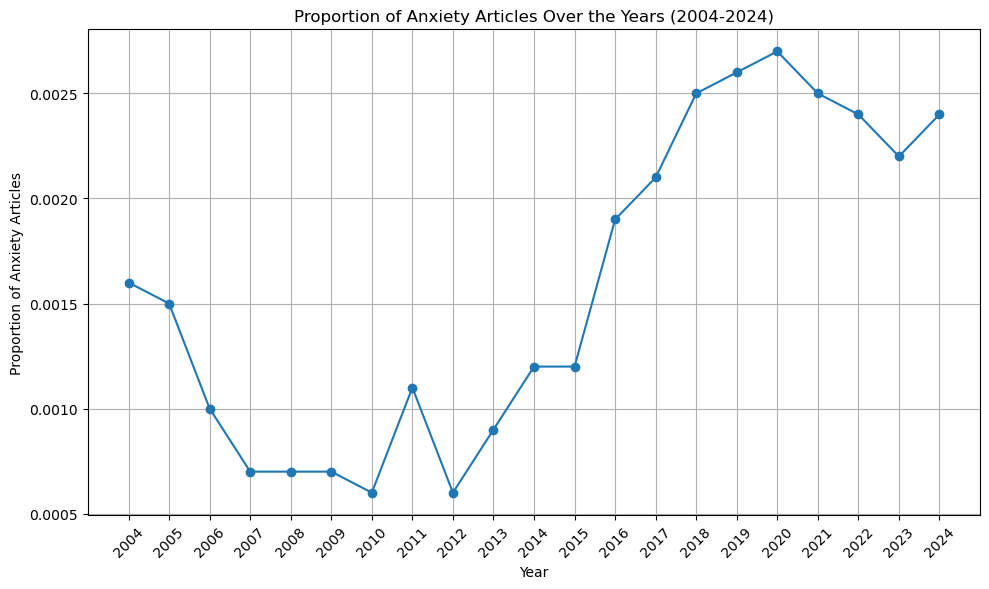

In [73]:
# Data
years = list(range(2004, 2025))
proportions = [
    0.0016, 0.0015, 0.001, 0.0007, 0.0007, 0.0007, 0.0006, 0.0011, 0.0006, 
    0.0009, 0.0012, 0.0012, 0.0019, 0.0021, 0.0025, 0.0026, 0.0027, 0.0025, 
    0.0024, 0.0022, 0.0024
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, proportions, marker='o', linestyle='-')
plt.title('Proportion of Anxiety Articles Over the Years (2004-2024)')
plt.xlabel('Year')
plt.ylabel('Proportion of Anxiety Articles')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()

# Show plot
plt.show()

#### hooray! We can actually see an significant increase, reached a peak during 2020, when  the pandemic hits the hardest

Proportion of Depression articles among all articles from The Guardian (YUE)

In [75]:
query = 'depression'
depression_articles = search_guardian_api(api_key, query, from_date, to_date)
dfd = pd.DataFrame(depression_articles)
dfd.to_csv('depression_articles.csv', index=False)

In [ ]:
# Convert 'Publication Date' column to datetime
dfd['Publication Date'] = pd.to_datetime(dfd['Publication Date'])

# Extract year from 'Publication Date' and create a new column
dfd['Year'] = dfd['Publication Date'].dt.year

# Count the number of articles for each year
yearly_counts_d = dfd['Year'].value_counts().sort_index()

# Display the yearly counts
print(yearly_counts_d)
print(len(dfd))

Year
2004    224
2005    166
2006    154
2007    147
2008    167
2009    133
2010     90
2011    160
2012    124
2013    132
2014    181
2015    164
2016    177
2017    161
2018    181
2019    181
2020    135
2021    126
2022    129
2023    147
2024     13
Name: count, dtype: int64
3092


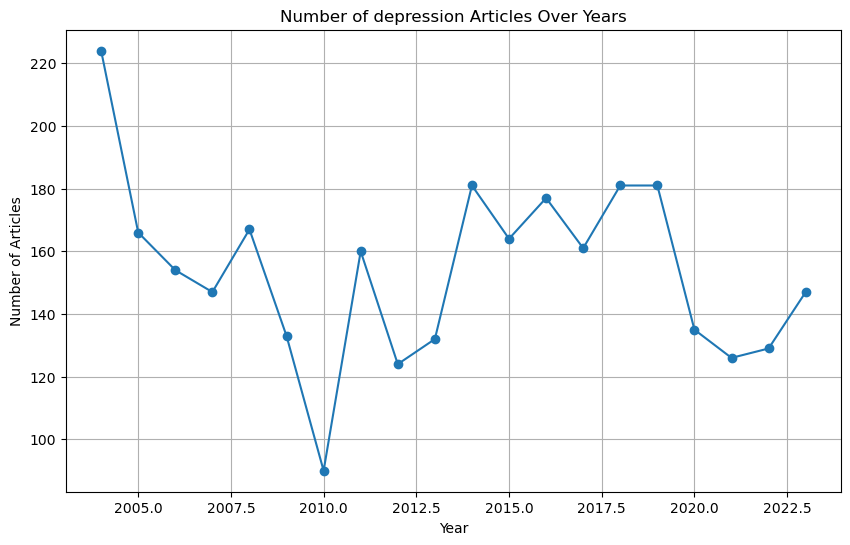

In [ ]:
years = list(range(2004, 2024))
values = [224, 166, 154, 147, 167, 133, 90, 160, 124, 132, 181, 164, 177, 161, 181, 181, 135, 126, 129, 147]

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(years, values, marker='o', linestyle='-')

# Add labels and title
plt.title('Number of depression Articles Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Articles')

# Show grid
plt.grid(True)

# Show plot
plt.show()

I got rid of 2024 for the same reason, only 2 months passed

#### Proportion of depression articles

In [ ]:
depression_counts = {
    2004: 224, 2005: 166, 2006: 154, 2007: 147, 2008: 167, 2009: 133, 2010: 90,
    2011: 160, 2012: 124, 2013: 132, 2014: 181, 2015: 164, 2016: 177, 2017: 161,
    2018: 181, 2019: 181, 2020: 135, 2021: 126, 2022: 129, 2023: 147, 2024: 13
}

# Calculate the proportion of depression articles to total articles for each year
proportion_depression_articles = {}
for year in range(2004, 2025):
    if total_articles[year] != 0:  # Avoid division by zero
        proportion_depression_articles[year] = depression_counts[year] / total_articles[year]
    else:
        proportion_depression_articles[year] = 0  # If total articles is 0, set proportion to 0

# Display the proportion of depression articles published for each year
for year, proportion in proportion_depression_articles.items():
    print(f"Year: {year}, Proportion of Depression Articles: {proportion:.4f}")

Year: 2004, Proportion of Depression Articles: 0.0023
Year: 2005, Proportion of Depression Articles: 0.0017
Year: 2006, Proportion of Depression Articles: 0.0014
Year: 2007, Proportion of Depression Articles: 0.0012
Year: 2008, Proportion of Depression Articles: 0.0012
Year: 2009, Proportion of Depression Articles: 0.0011
Year: 2010, Proportion of Depression Articles: 0.0008
Year: 2011, Proportion of Depression Articles: 0.0013
Year: 2012, Proportion of Depression Articles: 0.0010
Year: 2013, Proportion of Depression Articles: 0.0011
Year: 2014, Proportion of Depression Articles: 0.0015
Year: 2015, Proportion of Depression Articles: 0.0014
Year: 2016, Proportion of Depression Articles: 0.0016
Year: 2017, Proportion of Depression Articles: 0.0019
Year: 2018, Proportion of Depression Articles: 0.0023
Year: 2019, Proportion of Depression Articles: 0.0023
Year: 2020, Proportion of Depression Articles: 0.0017
Year: 2021, Proportion of Depression Articles: 0.0016
Year: 2022, Proportion of De

##### A plot to visualize 

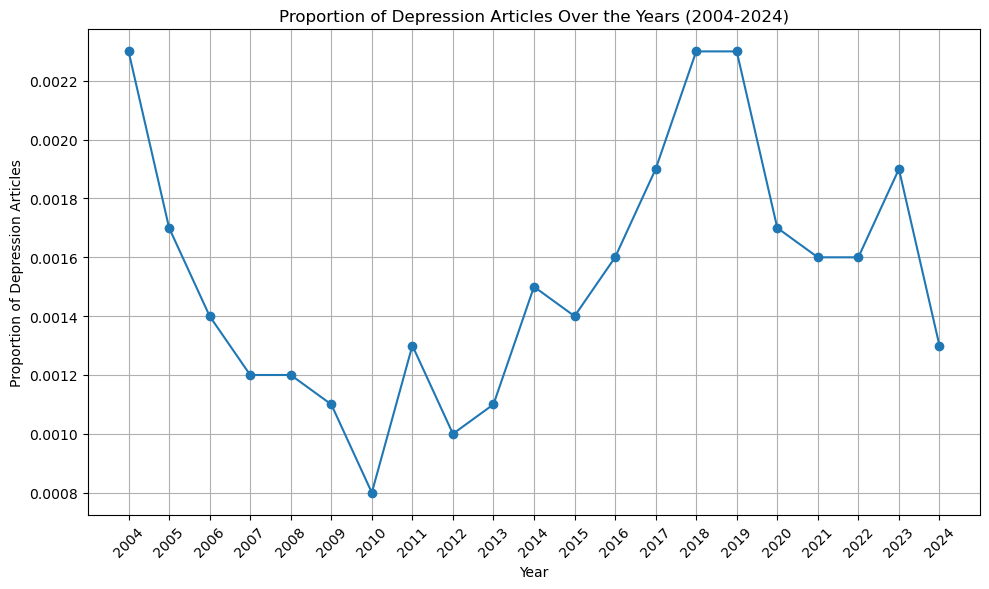

In [ ]:
years = list(range(2004, 2025))
proportions = [
    0.0023, 0.0017, 0.0014, 0.0012, 0.0012, 0.0011, 0.0008, 0.0013, 0.001, 
    0.0011, 0.0015, 0.0014, 0.0016, 0.0019, 0.0023, 0.0023, 0.0017, 0.0016, 
    0.0016, 0.0019, 0.0013
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, proportions, marker='o', linestyle='-')
plt.title('Proportion of Depression Articles Over the Years (2004-2024)')
plt.xlabel('Year')
plt.ylabel('Proportion of Depression Articles')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()

# Show plot
plt.show()

#### As for depression, it's not that salient, we need to carry out further investigation to see if "depression" may also refer to other things

In [76]:
print(len(depression_articles))
print(len(anxiety_articles))

3092
2949


**Part IV. Further data cleaning (KEXIN)**

In [78]:
from datetime import datetime
import re

anxiety_df = pd.read_csv('anxiety_articles.csv', low_memory=False)
depression_df = pd.read_csv('depression_articles.csv', low_memory=False)

anxiety_df['Anxiety or Depression'] = 0  # 0 for anxiety articles
depression_df['Anxiety or Depression'] = 1  # 1 for depression articles

combined_df = pd.concat([anxiety_df, depression_df], ignore_index=True)

combined_df.rename(columns={'Headline': 'Title'}, inplace=True)

combined_df['Sources'] = '1' # 1 for The Guardian

# Convert 'Publication Date' to datetime and remove rows with invalid or missing dates
combined_df['Publication Date'] = pd.to_datetime(combined_df['Publication Date'], errors='coerce')
combined_df = combined_df.dropna(subset=['Publication Date'])

# Remove timezone information from 'Publication Date'
combined_df['Publication Date'] = combined_df['Publication Date'].dt.tz_localize(None)

# Extract 'Month', 'Date', and 'Year'
combined_df['Month'] = combined_df['Publication Date'].dt.month
combined_df['Date'] = combined_df['Publication Date'].dt.day
combined_df['Year'] = combined_df['Publication Date'].dt.year

# Define the criteria for 'Time frame'
pre_date = datetime.strptime('2020-03-11', '%Y-%m-%d')
post_date = datetime.strptime('2023-05-11', '%Y-%m-%d')

# Function to determine the 'Time frame'
def determine_time_frame(row):
    if row['Publication Date'] < pre_date:
        return 0  # Pre
    elif row['Publication Date'] <= post_date:
        return 1  # During
    else:
        return 2  # Post

# Apply the function to set the 'Time frame'
combined_df['Time frame'] = combined_df.apply(determine_time_frame, axis=1)

# Remove the original 'Publication Date' column
combined_df.drop(columns=['Publication Date'], inplace=True)

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # 转换为小写
        text = re.sub(r'[^\w\s]', '', text)  # 移除非字母数字字符
        text = re.sub(r'\s+', ' ', text).strip()  # 将多个空格替换为单个空格，去除首尾空格
    else:
        text = ""
    return text

combined_df['Title'] = combined_df['Title'].apply(clean_text)
combined_df['Body Text'] = combined_df['Body Text'].apply(clean_text)

combined_df.dropna(subset=['Title', 'Body Text'], inplace=True)

combined_df = combined_df[['Sources', 'Month', 'Date', 'Year',
                           'Anxiety or Depression', 'Title',
                           'Body Text', 'Time frame']]

combined_df.to_csv('combined_articles.csv', index=False)

### Line Show frequency of articles over months (July 1, 2019-January 31, 2024) 


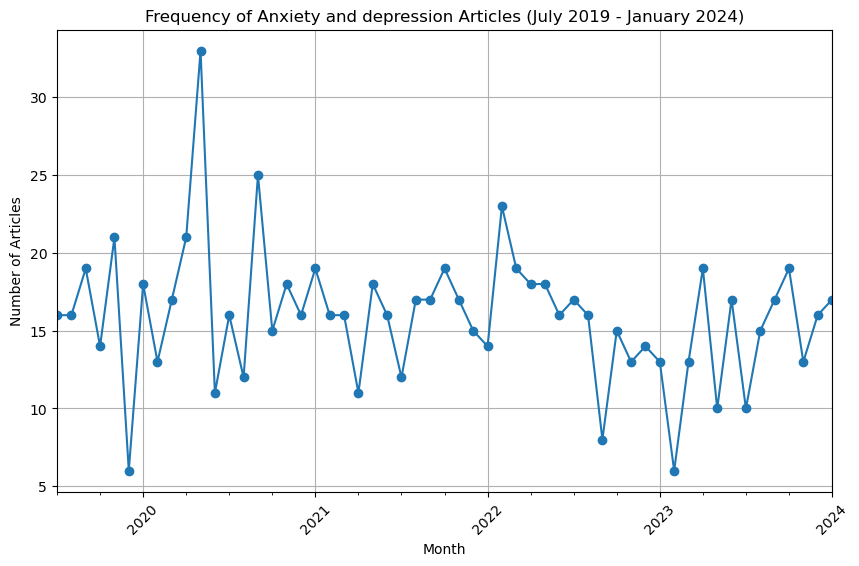

In [79]:
# Read the combined DataFrame from the CSV file
combined_df = pd.read_csv('combined_articles.csv')

# Convert 'Year' and 'Month' columns to datetime
combined_df['Date'] = pd.to_datetime(combined_df['Year'].astype(str) + '-' + combined_df['Month'].astype(str), format='%Y-%m')

# Filter articles within the specified time frame (July 1, 2019 to January 31, 2024)
filtered_df = combined_df[(combined_df['Date'] >= '2019-07-01') & (combined_df['Date'] <= '2024-01-31')]

# Group by month and count the number of anxiety articles
monthly_counts = filtered_df[filtered_df['Anxiety or Depression'] == 0].groupby('Date').size()

# Plot the frequency of anxiety articles over months
monthly_counts.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Frequency of Anxiety and depression Articles (July 2019 - January 2024)')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

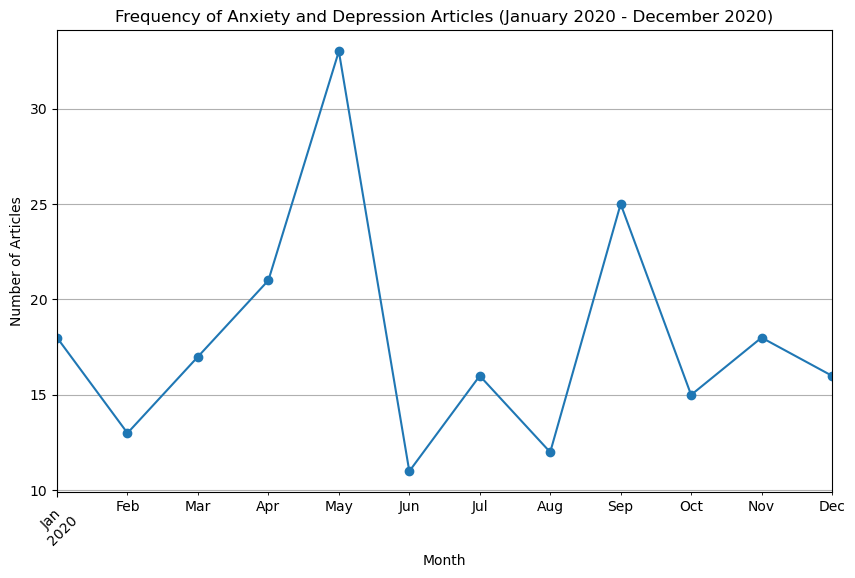

In [80]:

# Read the combined DataFrame from the CSV file
combined_df = pd.read_csv('combined_articles.csv')

# Convert 'Year' and 'Month' columns to datetime
combined_df['Date'] = pd.to_datetime(combined_df['Year'].astype(str) + '-' + combined_df['Month'].astype(str), format='%Y-%m')

# Filter articles within the specified time frame (January 1, 2020 to December 31, 2020)
filtered_df = combined_df[(combined_df['Date'] >= '2020-01-01') & (combined_df['Date'] <= '2020-12-31')]

# Group by month and count the number of anxiety articles
monthly_counts = filtered_df[filtered_df['Anxiety or Depression'] == 0].groupby('Date').size()

# Plot the frequency of anxiety articles over months for the year 2020
monthly_counts.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Frequency of Anxiety and Depression Articles (January 2020 - December 2020)')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### We can see a significant increase in APR and May. Maybe check news to see if any regulation impacted.